In [528]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

# EDA

## Описание датасета

- UID: уникальный идентификатор от 1 to 10000
- productID: имеет вид `(LMH)(serial number)`, где L, M, H означает качество продукта (low, medium, high соответственно), а serial number --- серийный номер продукта
- air temperature [K]: температура воздуха
process temperature [K]: температура машины во время работы
- rotational speed [rpm]: скорость вращения
- torque [Nm]: момент силы
- tool wear [min]: накопленный износ иструмента
---
Здесь *два* целевых признака:
- failure: сломалась ли машина 
- failure type: описание поломки

In [529]:
df = (
    pd
        .read_csv('../data/machine_predictive_maintenance/predictive_maintenance.csv')
        .rename(columns=dict(UDI='UID')) # there is a typo in the dataset
)


In [530]:
df.head()

UID Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure

In [531]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UID                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


## Первичный анализ целевых признаков

Посмотрим статистику по целевым признакам

In [532]:
df['Target'].value_counts()

Target
0    9661
1     339
Name: count, dtype: int64

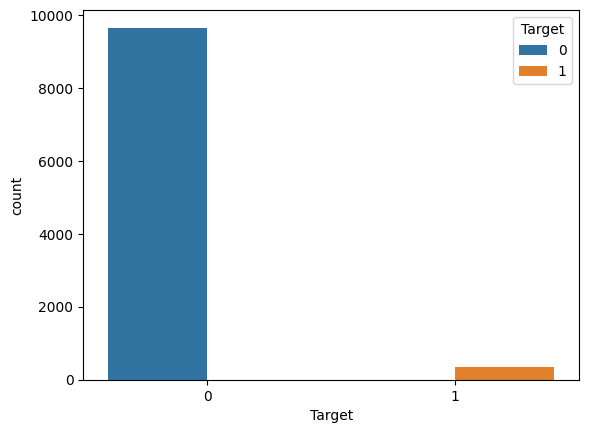

In [533]:
sns.countplot(data=df, x='Target', hue='Target');

In [534]:
df['Target'].mean()

0.0339

Таким образом, ~3% машин из выборки дали сбой. Посмотрим теперь на второй целевой признак

In [535]:
df['Failure Type'].value_counts()

Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64

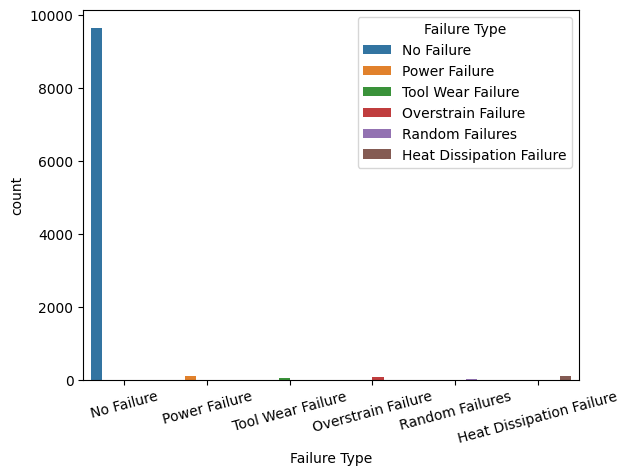

In [536]:
g = sns.countplot(df, x='Failure Type', hue='Failure Type')
plt.xticks(rotation=15);

Так мало что видно, поэтому нарисуем с логарифмическим масштабом

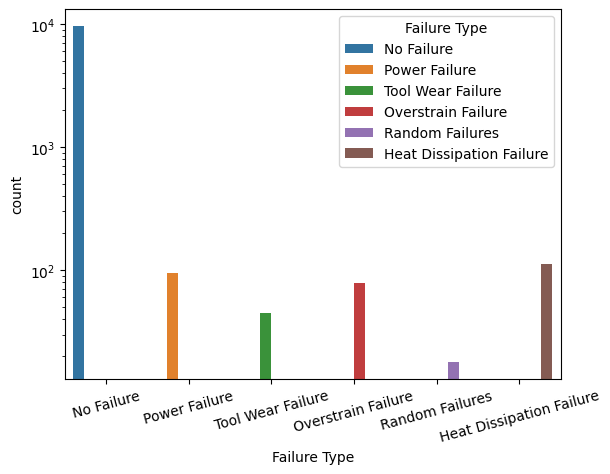

In [537]:
g = sns.countplot(df, x='Failure Type', hue='Failure Type')
g.set_yscale('log')
plt.xticks(rotation=15);

In [538]:
df[df['Failure Type'] != 'No Failure']['Failure Type'].value_counts(normalize=True)

Failure Type
Heat Dissipation Failure    0.321839
Power Failure               0.272989
Overstrain Failure          0.224138
Tool Wear Failure           0.129310
Random Failures             0.051724
Name: proportion, dtype: float64

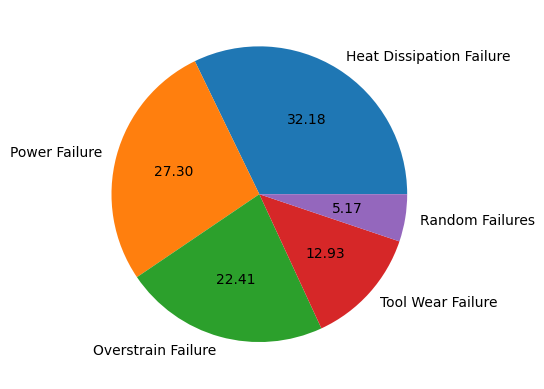

In [539]:
g = df[df['Failure Type'] != 'No Failure']['Failure Type'].value_counts().plot(kind='pie', autopct='%.2f')
g.set_ylabel(None);

Большинство сбоев связаны со сбоями теплоотведения (32%). Пока, конечно, это мало о чем говорит.

## Анализ нецелевых признаков

### Количественные признаки

In [540]:
cont_df = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]

In [541]:
cont_df.describe()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
count         10000.000000             10000.000000            10000.000000   
mean            300.004930               310.005560             1538.776100   
std               2.000259                 1.483734              179.284096   
min             295.300000               305.700000             1168.000000   
25%             298.300000               308.800000             1423.000000   
50%             300.100000               310.100000             1503.000000   
75%             301.500000               311.100000             1612.000000   
max             304.500000               313.800000             2886.000000   

        Torque [Nm]  Tool wear [min]  
count  10000.000000     10000.000000  
mean      39.986910       107.951000  
std        9.968934        63.654147  
min        3.800000         0.000000  
25%       33.200000        53.000000  
50%       40.100000       108.000000  
75%       46.800000       162.000000  
max       76.600000       253.000000

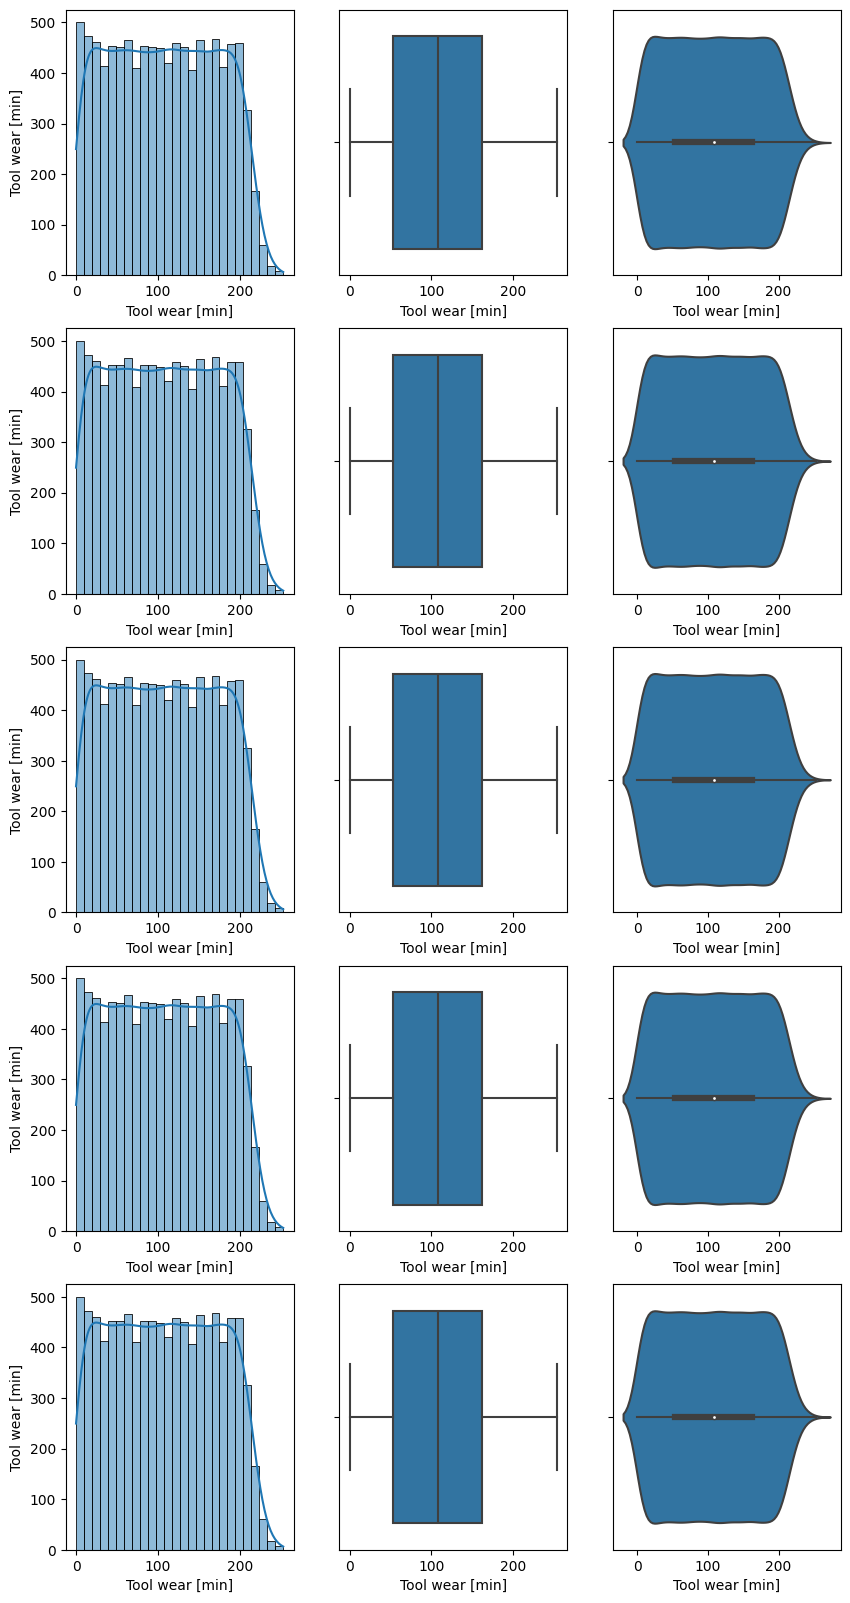

In [542]:
fig, axes = plt.subplots(nrows=cont_df.shape[1], ncols=3, figsize=(10, 20))
for i, feat in enumerate(cont_df.columns):
    sns.histplot(x=cont_df[col], kde=True, ax=axes[i, 0])
    sns.boxplot(x=cont_df[col], ax=axes[i, 1])
    sns.violinplot(x=cont_df[col], ax=axes[i, 2])
    axes[i, 0].set_ylabel(col)


Можем заметить
- В распределении `Air temperature` присутствует что-то вроде двух пиков
- Распределение `Rotational speed` асимметричное и "острое" (хотя последнее тяжело определить простым взглядом, особенно учитывая растянуость графиков)
- Распределение `Torque` симметрично, но тоже выглядит остро

Посмотрим на третий и четвертый моменты `Rotational speed` и `Torque` (коэффициенты асимметричности и эксцесса соответственно)

In [543]:
cont_df['Rotational speed [rpm]'].skew()

1.9931710047137523

In [544]:
cont_df['Rotational speed [rpm]'].kurtosis()

7.392944899246485

In [545]:
cont_df['Torque [Nm]'].skew()

-0.00951659584005855

In [546]:
cont_df['Torque [Nm]'].kurtosis()

-0.013240614017021368

Действительно, `Rotational speed` и 1) сильно смещена и 2) "остра". Последнее означает, что в выборке может быть много выбросов, что отлично видно на boxplot-е `Rotational speed`. 
В то же время `Torque` оказался совсем не острым.

In [547]:
df.head()

UID Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
0                    1551         42.8                0       0   No Failure  
1                    1408         46.3                3       0   No Failure  
2                    1498         49.4                5       0   No Failure  
3                    1433         39.5                7       0   No Failure  
4                    1408         40.0                9       0   No Failure

### Категориальные признаки

Категориальные признаков всего два: `Product ID` и `Type`, причем `Type` --- это и есть идентификатор качества продукта, использующийся в `Product ID`:

In [548]:
df[df['Product ID'].str[0] != df['Type']].shape

(0, 10)

Кроме того, серийный номер при не имеет полезной нагрузки, т.к. для у нас уже есть уникальные идентификаторы (`UID`). Поэтому от `Product ID` можно с чистой совестью избавиться

In [549]:
df.drop(columns='Product ID', inplace=True)

Перейдем к `Type`

In [550]:
df['Type'].value_counts()

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64

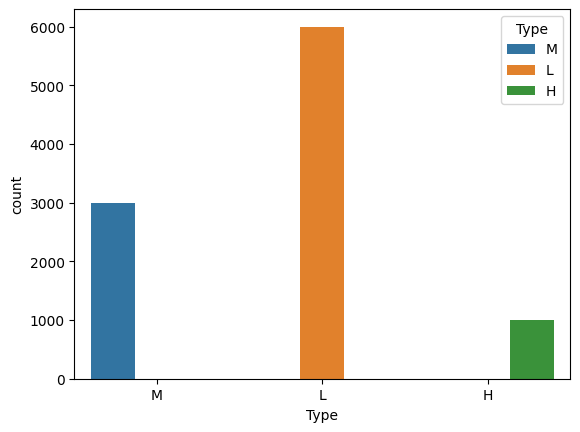

In [551]:
sns.countplot(df, x='Type', hue='Type');

## Нецелевые vs целевые

### Количественные признаки

In [552]:
cont_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
cont_df = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'Failure Type']]

#### vs Target (Failed)

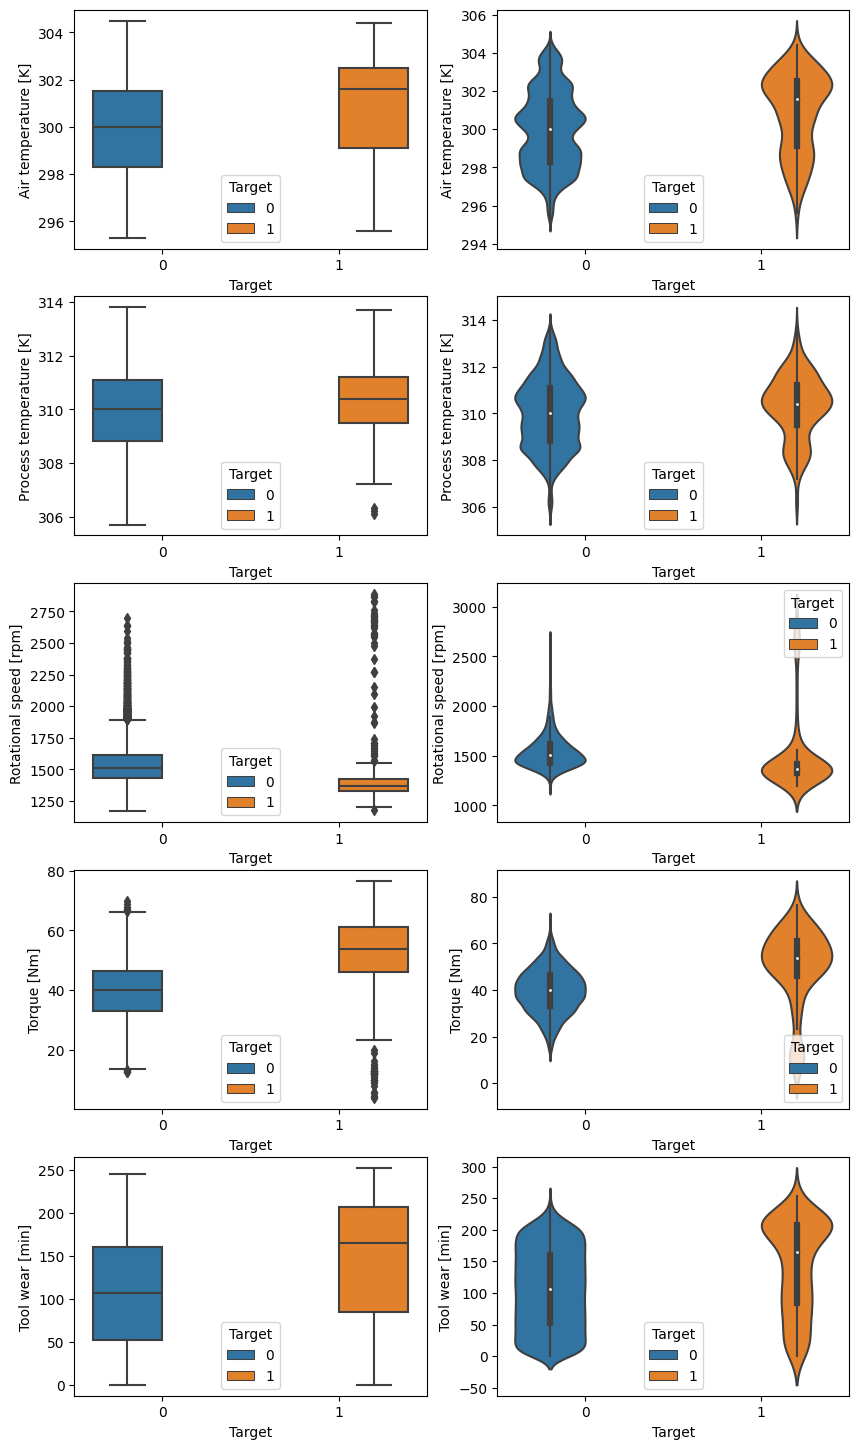

In [553]:
_, axes = plt.subplots(len(cont_cols), 2, figsize=(10, 18))
for i, feat in enumerate(cont_cols):
    sns.boxplot(x='Target', y=feat, data=cont_df, hue='Target', ax=axes[i, 0])
    sns.violinplot(x='Target', y=feat, data=cont_df, hue='Target', ax=axes[i, 1])
    axes[i, 0].set_ylabel(feat)

- Когда температура воздуха выше, доля поломок также больше
- Сбои не зависят от `Process temperature` и `Rotation speed`
- Доля сломавшихся с большим значением `Torque` больше
- Чем выше износ, тем больше поломок

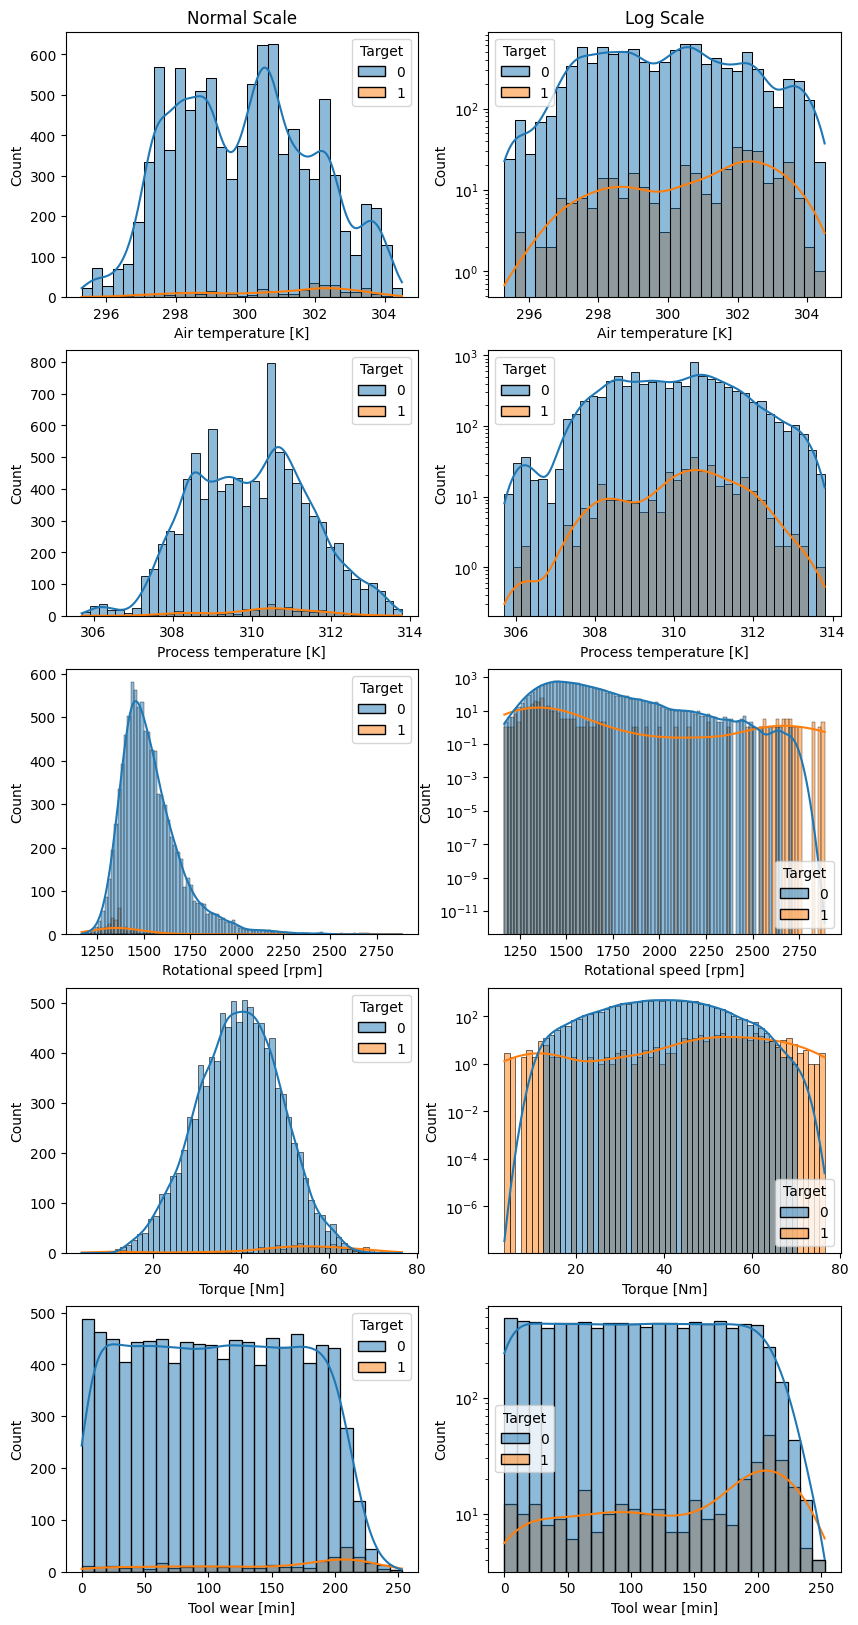

In [554]:
_, axes = plt.subplots(len(cont_cols), 2, figsize=(10, 20))
for i, feat in enumerate(cont_cols):
    nscale_g = sns.histplot(x=feat, data=cont_df, hue='Target', kde=True, ax=axes[i, 0])
    logscale_g = sns.histplot(x=feat, data=cont_df, hue='Target', kde=True, ax=axes[i, 1])
    if i == 0:
        nscale_g.set_title('Normal Scale')
        logscale_g.set_title("Log Scale")
    logscale_g.set_yscale("log")

#### vs Failure Type

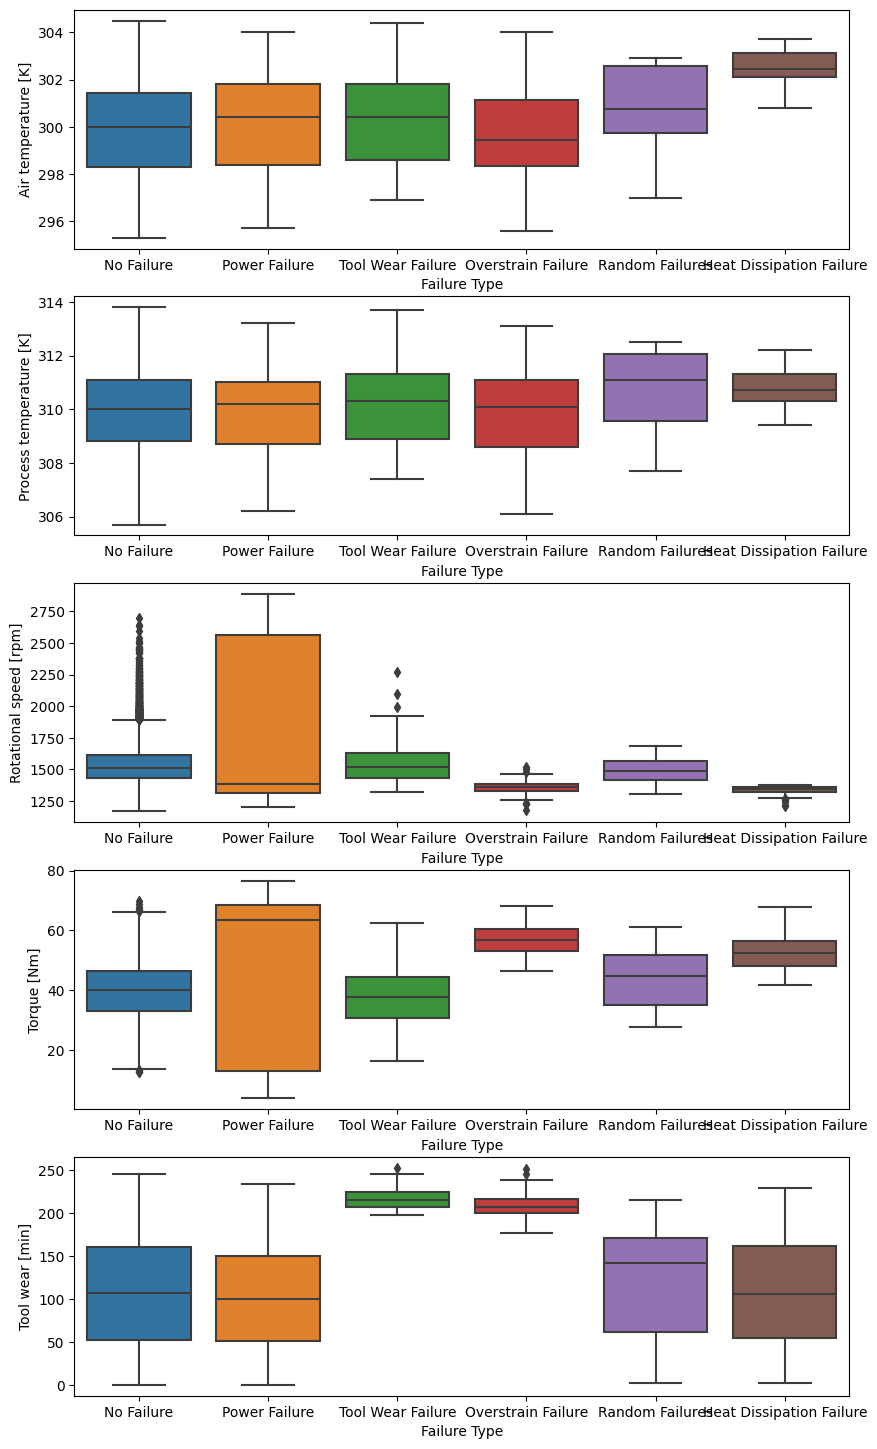

In [555]:
_, axes = plt.subplots(len(cont_cols), figsize=(10, 18))
for i, feat in enumerate(cont_cols):
    sns.boxplot(x='Failure Type', y=feat, data=cont_df, ax=axes[i])
    axes[i].set_ylabel(feat)

- В машинах, сломавшихся из-за теплоотведения, температурные величины были несколько выше (что, наверное, понятно), хотя в случае `Process temperature` это выражено не так сильно
- Перегрузочные сбои, а также сбои из-за теплоотведения, коррелируют с более высоким значением `Torque` и более низким `Rotational speed`
- Износ (очевидно) имеет место в поломках, связанных с износом, а также (уже не так очевидно) в перегрузочных сбоях
- Пока что может казаться, что перебои питания будет сложно предсказывать, поскольку в одном случае они происходят либо совсем независимо от нецелевых величин (например, `Torque`), а в другом они неотделимы от других видов сбоев


### Категориальный признак Type

#### vs Target

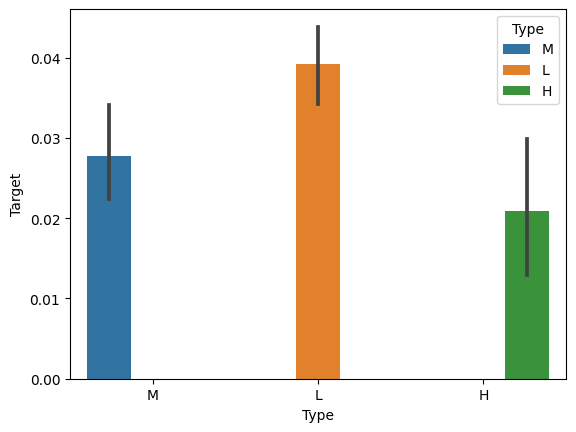

In [556]:
sns.barplot(x='Type', y='Target', hue='Type', data=df);

Как можно видеть, больше всего сломалось машин категории Low quality, а меньше всего --- High quality. Это может быть связано с тем, что чем выше категория, тем "лучше" машина, но скорее такая картинка возникает из-за того, что машин более низких категорий просто больше (что видно на следующем чарте)

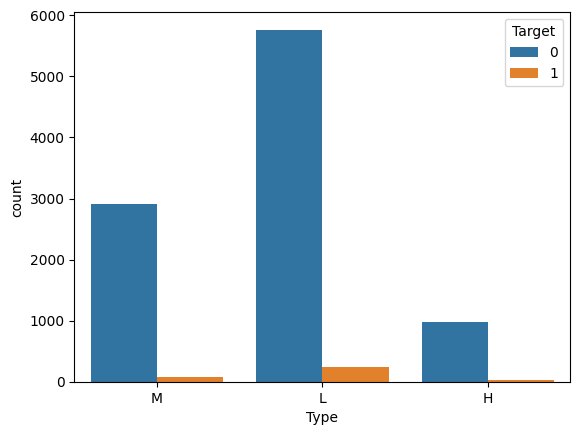

In [557]:
sns.countplot(x='Type', hue='Target', data=df);

#### vs Failure Type

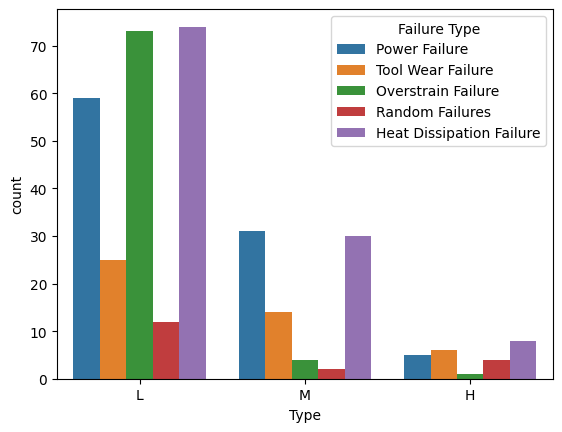

In [558]:
sns.countplot(x='Type', hue='Failure Type', data=df[df['Failure Type'] != 'No Failure']);

- Большая доля машин низкого качества страдает от перегрузок
- Проблемы с теплоотведением является одной из главных в каждой из категорий
- В большинстве случаев наблюдается одинаковый тренд --- чем выше качество, тем меньше поломок, и причины поломок +- упорядочены (heat dissipation >= power failure >= tool wear >= overstrain >= random), за исключением, быть может, немного возросшего количества случайных сбоев в высшей категории

## Взаимодействие нецелевых с нецелевыми

### Количественные с количественными

In [559]:
cont_df = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']]

<Axes: >

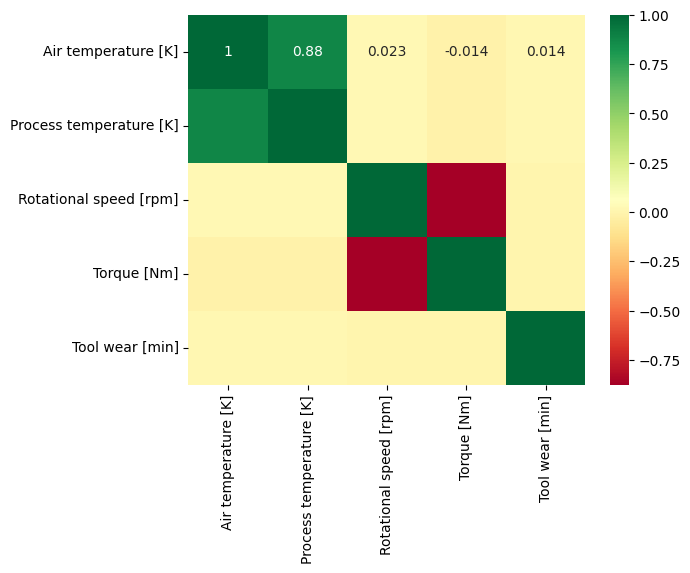

In [560]:
sns.heatmap(cont_df.corr(), annot=True, cmap='RdYlGn')

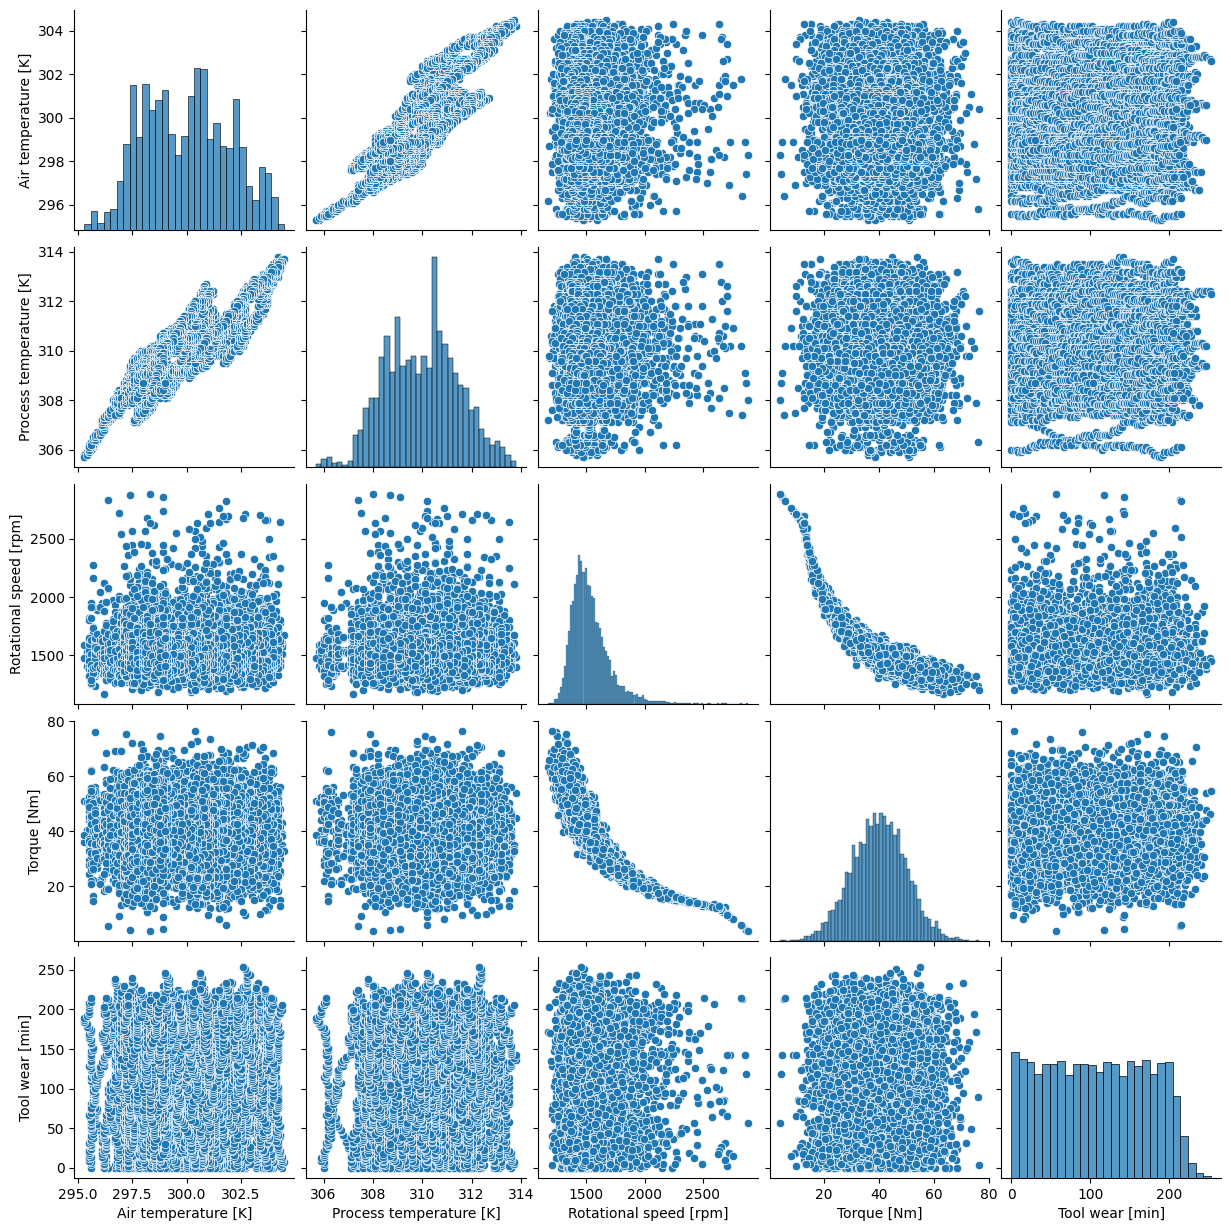

In [561]:
sns.pairplot(cont_df);

- Есть большая коррелляция (0.88) между `Air temperature` и `Process temperature`
- Также большая отрицательная коррелляция (-0.88) между `Rotational speed` и `Torque`

В каждом случае можем избавиться от одного из признаков

### Количественные с категориальным Type

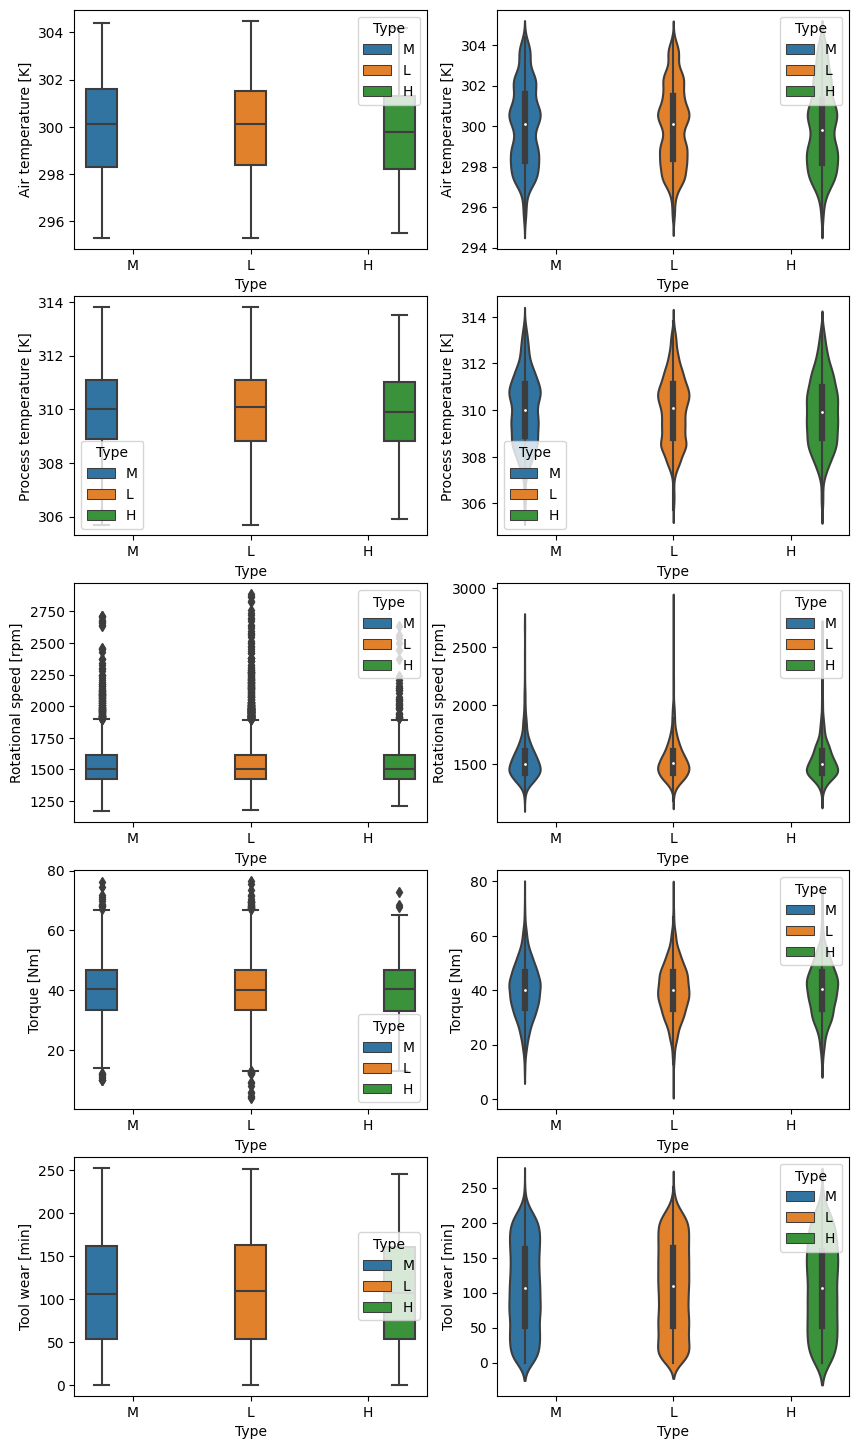

In [562]:
_, axes = plt.subplots(len(cont_cols), 2, figsize=(10, 18))
for i, feat in enumerate(cont_cols):
    sns.boxplot(x='Type', y=feat, data=df, hue='Type', ax=axes[i, 0])
    sns.violinplot(x='Type', y=feat, data=df, hue='Type', ax=axes[i, 1])
    axes[i, 0].set_ylabel(feat)

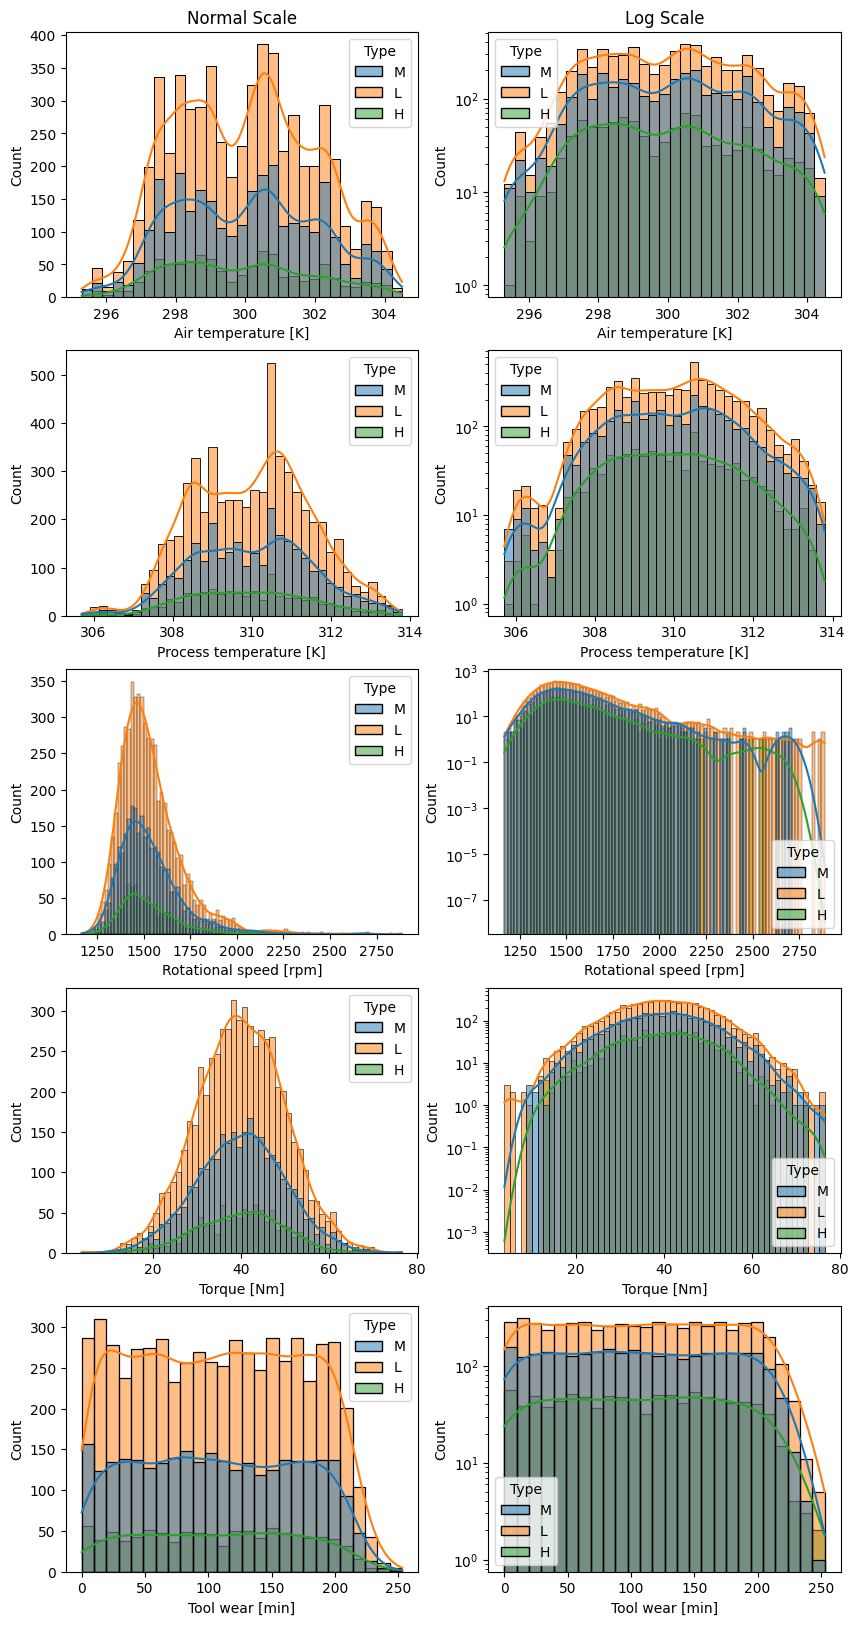

In [563]:
_, axes = plt.subplots(len(cont_cols), 2, figsize=(10, 20))
for i, feat in enumerate(cont_cols):
    nscale_g = sns.histplot(x=feat, data=df, hue='Type', kde=True, ax=axes[i, 0])
    logscale_g = sns.histplot(x=feat, data=df, hue='Type', kde=True, ax=axes[i, 1])
    if i == 0:
        nscale_g.set_title('Normal Scale')
        logscale_g.set_title("Log Scale")
    logscale_g.set_yscale("log")

Хотя можно было ожидать, что у машин более низкой категории показатели будут хуже, такого не наблюдается

## Несколько нецелевых vs целевые

### Target

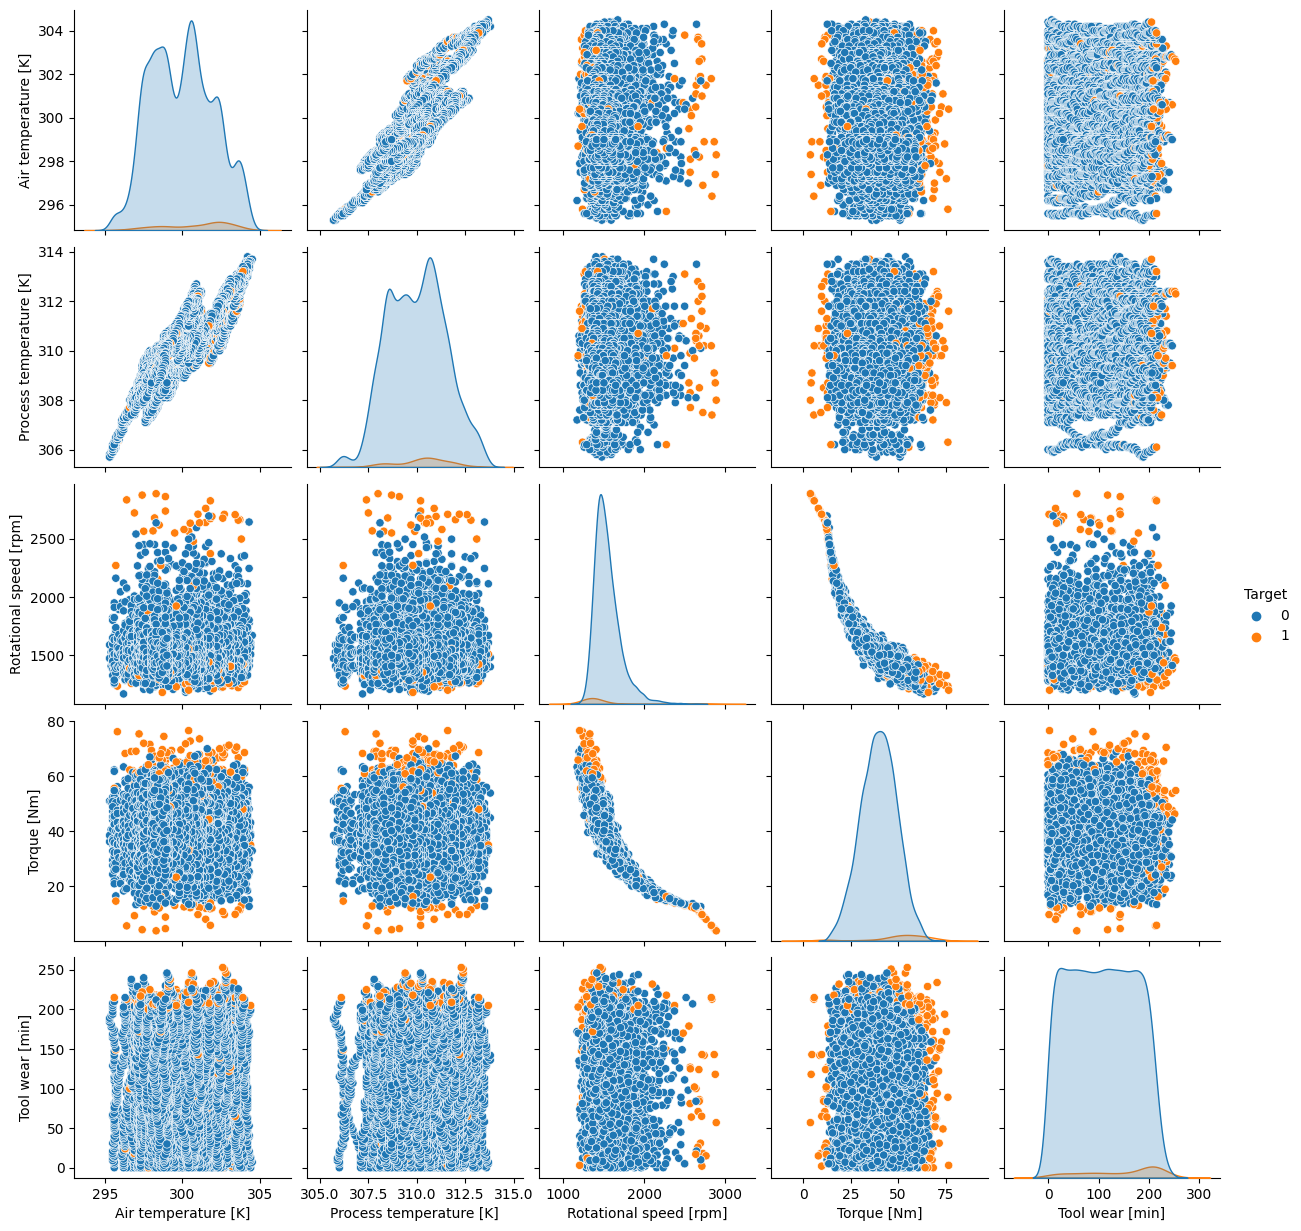

In [564]:
sns.pairplot(df[cont_cols + ['Target']], hue='Target');

В основном желтые точки (соответствующие сломавшимся машинам) простираются целиком на одну из осей, т.е. нет видимой зависимости целевой переменной от совокупности двух (количественных) нецелевых

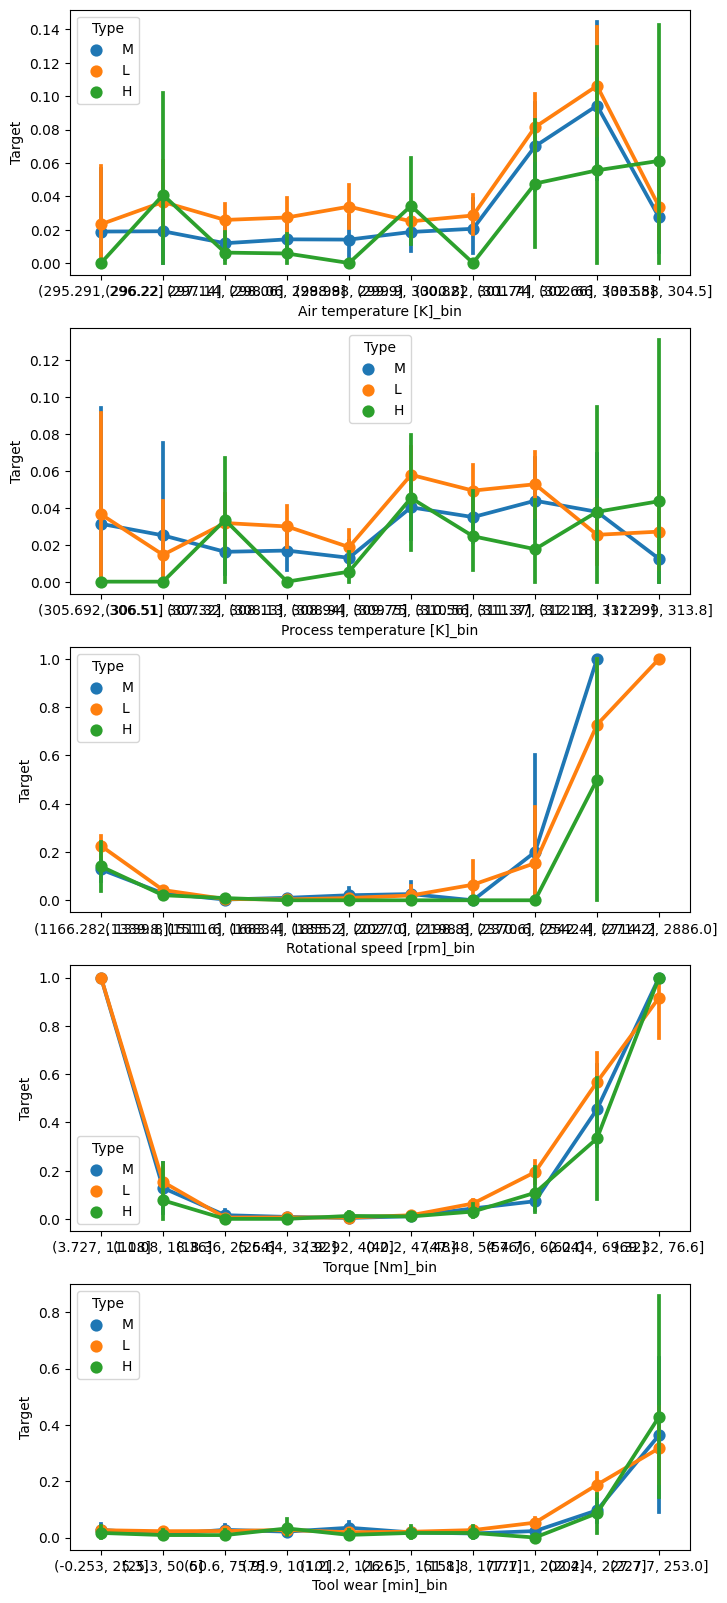

In [565]:
# TODO: beautify these plots
_, axes = plt.subplots(nrows=len(cont_cols), figsize=(8, 20))
for i, feat in enumerate(cont_cols):
    df[f'{feat}_bin'] = pd.cut(df[feat], 10)
    sns.pointplot(x=f'{feat}_bin', y='Target', hue='Type', data=df, ax=axes[i])

Похоже, что во всех случаях наблюдается одинаковый тренд вне зависимости от категории качества

### Failure Type

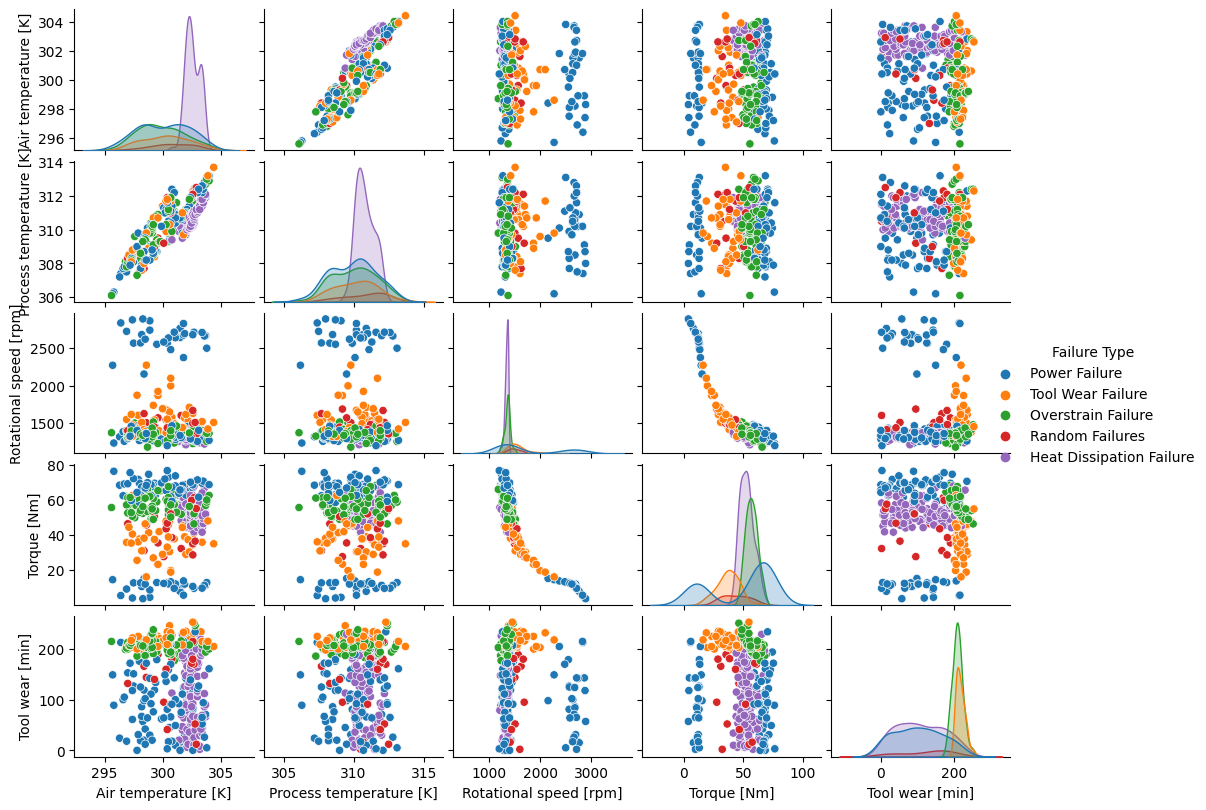

In [566]:
cont_with_ftypes = cont_cols + ['Failure Type']
g = sns.pairplot(df[df['Failure Type'] != 'No Failure'][cont_with_ftypes], hue='Failure Type');
g.fig.set_size_inches(12, 8)

- Сильный износ + малая скорость вращения (или износ + высокий `Torque`) влияют на перегрузочные сбои
- Сильный износ + средняя-высокая скорость вращения (или износ + малый-средний `Torque`) влияют на сбои, связанные с износом


# Preprocessing

In [567]:
df['Type'].replace({
    'L': 0,
    'M': 1,
    'H': 2
}, inplace=True)

df['Failure Type'].replace({
    'No Failure': 0,
    'Power Failure': 1,
    'Tool Wear Failure': 2,
    'Overstrain Failure': 3,
    'Random Failures': 4,
    'Heat Dissipation Failure': 5
}, inplace=True)

In [568]:
y_target = df['Target']
y_ftype = df['Failure Type']
df = df[['Type', 'Air temperature [K]', 'Torque [Nm]', 'Tool wear [min]']].rename(
    columns={'Type': 'type', 'Air temperature [K]': 'air_temp', 'Torque [Nm]': 'torque', 'Tool wear [min]': 'tool_wear'}
)

# Подбор параметров и тренировка моделей

In [569]:
from loguru import logger

## MyBagging

In [570]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaseEnsemble
from sklearn.base import BaseEstimator

In [736]:
class MyBaggingClassifier(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=5, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state

    def fit(self, X, y):
        self._models = []
        for _ in range(self.n_estimators):
            X_loc, y_loc = resample(X, y, random_state=self.random_state)
            model = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            model.fit(X_loc, y_loc)
            self._models.append(model)

    def predict(self, X):
        predictions = []
        for model in self._models:
            model_prediction = model.predict(X)
            # print("Tree predictions:", np.unique(tree_predictions))
            predictions.append(model_prediction)
        
        predictions = np.array(predictions)
        majority_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x)), axis=0, arr=predictions)
        # print("Majority vote:", np.unique(majority_vote))
        return majority_vote

## MyAdaBoosting

In [737]:
class MyAdaBoosting(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=5, random_state=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state

    def fit(self, X, y):
        self._models = []
        self._alphas = []
        weights = np.full(len(X), 1 / len(X))
        
        for i in range(self.n_estimators):
            model = DecisionTreeClassifier(max_depth=self.max_depth, random_state=self.random_state)
            model.fit(X, y, weights)
            e = 1 - model.score(X, y, weights)
            # print(e)
            self._alphas.append(np.log((1 - e) / e) / 2)
            weights = weights * np.exp(self._alphas[i] * (y != model.predict(X)))
            weights = weights / np.sum(weights)
            self._models.append(model)
        self._alphas = self._alphas / np.sum(self._alphas)

    def predict(self, X):
        return np.around(np.sum([alpha * model.predict(X) for alpha, model in zip(self._alphas, self._models)], axis=0))

## Делим датасет

In [576]:
import optuna
import optuna_integration
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [577]:
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(df, y_target, test_size=0.2, random_state=42)
X_train_type, X_test_type, y_train_type, y_test_type = train_test_split(df, y_ftype, test_size=0.2, random_state=42)

## Подбор параметров

In [578]:
def tune(estimator, params, X_train, y_train):
    study = optuna.create_study(direction='maximize')
    model = optuna.integration.OptunaSearchCV(
        estimator=estimator,
        param_distributions=params,
        scoring='accuracy',
        study=study,
        random_state=42,
    )

    results = cross_validate(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=StratifiedKFold(shuffle=True, random_state=42),
        scoring='accuracy',
        return_estimator=True
    )

    df = pd.DataFrame(results)
    df['best_params'] = df['estimator'].apply(lambda x : x.best_params_)
    df.drop(columns='estimator', inplace=True)

    return pd.concat([df.drop(columns='best_params'), df['best_params'].apply(pd.Series)], axis=1)

In [579]:
def run_tune(ensembles, X, y):
    tune_result_list = []
    for ensemble in ensembles:
        df = tune(**ensemble, X_train=X, y_train=y)
        df['name'] = type(ensemble['estimator']).__name__
        tune_result_list.append(df)
    
    return pd.concat(tune_result_list)

In [738]:
ensembles = [
    {
        'estimator': BaggingClassifier(random_state=42),
        'params': {
            'n_estimators': optuna.distributions.CategoricalDistribution([5, 10, 15, 20, 35, 50, 100]),
            'max_samples': optuna.distributions.CategoricalDistribution([1 / 3, 2 / 3, 1]),
            'max_features': optuna.distributions.CategoricalDistribution([1 / 3, 2 / 3, 1])
        }
    },
    {
        'estimator': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': optuna.distributions.CategoricalDistribution([5, 10, 15, 20, 35, 50, 100]),
            'max_depth': optuna.distributions.CategoricalDistribution([1, 2, 3, 5, 7, 10]),
            'min_samples_split': optuna.distributions.CategoricalDistribution([2, 3, 4, 5]),
            'min_samples_leaf': optuna.distributions.CategoricalDistribution([1, 2, 3, 4, 5]),
        }
    },
    {
        'estimator': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': optuna.distributions.CategoricalDistribution([5, 10, 15, 20, 35, 50, 100]),
        }
    },
    {
        'estimator': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': optuna.distributions.CategoricalDistribution([5, 10, 15, 20, 35, 50, 100]),
            'max_depth': optuna.distributions.CategoricalDistribution([1, 2, 3, 5, 7]),
            'max_features': optuna.distributions.CategoricalDistribution([1 / 3, 2 / 3, 1])
        }
    },
    {
        'estimator': HistGradientBoostingClassifier(random_state=42),
        'params': {
            'max_iter': optuna.distributions.CategoricalDistribution([5, 10, 15, 20]),
            'max_depth': optuna.distributions.CategoricalDistribution([1, 2, 3, 5, 7]),
            'max_features': optuna.distributions.CategoricalDistribution([1 / 3, 2 / 3, 1])
        }
    },
    {
        'estimator': XGBClassifier(random_state=42),
        'params': {
            'n_estimators': optuna.distributions.CategoricalDistribution([5, 10, 15, 20, 35, 50, 100]),
            'max_depth': optuna.distributions.CategoricalDistribution([1, 2, 3, 5, 7]),
        }
    },
    {
        'estimator': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': optuna.distributions.CategoricalDistribution([5, 10, 15, 20, 35, 50, 100]),
            'max_depth': optuna.distributions.CategoricalDistribution([1, 2, 3, 5, 7]),
            'num_leaves': optuna.distributions.CategoricalDistribution([10, 20, 30, 40, 50]),
        }
    },
    {
        'estimator': CatBoostClassifier(random_state=42),
        'params': {
            'n_estimators': optuna.distributions.CategoricalDistribution([5, 10, 15, 20, 35, 50, 100]),
            'depth': optuna.distributions.CategoricalDistribution([1, 2, 3, 5, 7]),
        }
    },
    ############################
    {
        'estimator': MyBaggingClassifier(random_state=42),
        'params': {
            'n_estimators': optuna.distributions.CategoricalDistribution([5, 10, 15, 20, 35, 50, 100]),
            'max_depth': optuna.distributions.CategoricalDistribution([1, 2, 3, 5, 7, 10]),
        }
    },
    {
        'estimator': MyAdaBoosting(random_state=42),
        'params': {
            'n_estimators': optuna.distributions.CategoricalDistribution([5, 10, 15, 20, 35, 50, 100]),
            'max_depth': optuna.distributions.CategoricalDistribution([1, 2, 3, 5, 7, 10]),
        }
    },
]

### Target

In [ ]:
target_tune_result = run_tune(ensembles, X_train_target, y_train_target);

In [582]:
target_tune_result

fit_time  score_time  test_score  n_estimators  max_samples  max_features  \
0   2.034507    0.003397    0.966875          10.0     0.333333      0.666667   
1   1.755875    0.003416    0.970625          15.0     0.666667      0.666667   
2   3.079552    0.005905    0.972500          35.0     0.666667      0.666667   
3   3.200884    0.002806    0.967500          10.0     0.333333      0.666667   
4   3.573318    0.007175    0.968750          50.0     0.333333      0.666667   
0   3.113322    0.003836    0.975625          35.0          NaN           NaN   
1   7.281117    0.007855    0.977500         100.0          NaN           NaN   
2   5.270145    0.008019    0.976250         100.0          NaN           NaN   
3   4.455171    0.004699    0.973750          50.0          NaN           NaN   
4   2.954087    0.002551    0.975000          20.0          NaN           NaN   
0   6.687753    0.013445    0.966250         100.0          NaN           NaN   
1   3.758138    0.003161    0.971875          15.0          NaN           NaN   
2   2.369121    0.007940    0.968125          35.0          NaN           NaN   
3   2.809635    0.005910    0.974375          35.0          NaN           NaN   
4   3.373645    0.003173    0.967500          15.0          NaN           NaN   
0   2.923303    0.001802    0.977500          15.0          NaN      0.666667   
1   3.204607    0.002180    0.971875         100.0          NaN      0.666667   
2   2.641237    0.002008    0.975000          50.0          NaN      0.666667   
3   3.679211    0.002126    0.975625         100.0          NaN      0.666667   
4   2.387756    0.002927    0.971250          35.0          NaN      1.000000   
0   0.477561    0.002093    0.976250           NaN          NaN      0.666667   
1   0.586194    0.002017    0.973125           NaN          NaN      0.666667   
2   0.734896    0.002473    0.974375           NaN          NaN      0.666667   
3   0.603518    0.002483    0.973125           NaN          NaN      0.666667   
4   0.469321    0.002929    0.972500           NaN          NaN      0.666667   
0   1.181083    0.002885    0.975000          50.0          NaN           NaN   
1   1.010716    0.002323    0.974375          20.0          NaN           NaN   
2   1.372771    0.002620    0.973750          35.0          NaN           NaN   
3   1.458353    0.002458    0.973125          20.0          NaN           NaN   
4   1.239575    0.002463    0.977500          35.0          NaN           NaN   
0   0.618447    0.001885    0.975000          20.0          NaN           NaN   
1   0.637649    0.002465    0.976250          50.0          NaN           NaN   
2   0.533243    0.002049    0.975000          15.0          NaN           NaN   
3   0.788047    0.003080    0.972500          35.0          NaN           NaN   
4   0.644612    0.002421    0.974375          20.0          NaN           NaN   
0   2.238175    0.001518    0.976250          35.0          NaN           NaN   
1   1.855456    0.001547    0.974375          20.0          NaN           NaN   
2   2.562573    0.001474    0.974375          15.0          NaN           NaN   
3   2.030328    0.001761    0.971875         100.0          NaN           NaN   
4   1.975187    0.001550    0.974375          50.0          NaN           NaN   
0   5.300939    0.017328    0.970625          35.0          NaN           NaN   
1   8.162746    0.010402    0.972500          20.0          NaN           NaN   
2   6.165168    0.003179    0.975625           5.0          NaN           NaN   
3  11.269701    0.003230    0.972500           5.0          NaN           NaN   
4   6.396212    0.007822    0.971250          15.0          NaN           NaN   
0  13.389730    0.008147    0.970625          15.0          NaN           NaN   
1   6.841554    0.017658    0.975625          35.0          NaN           NaN   
2  10.846936    0.003231    0.972500           5.0          NaN           NaN   
3  11.253924    0.008626    0.97312

In [739]:
target_ensembles_best = [
    {
        'name': 'BaggingClassifier',
        'estimator': BaggingClassifier,
        'params': {
            'n_estimators': 10,
            'max_samples': 1 / 3,
            'max_features': 2 / 3
        }
    },
    {
        'name': 'RandomForestClassifier',
        'estimator': RandomForestClassifier,
        'params': {
            'n_estimators': 100,
            'max_depth': 10,
            'min_samples_split': 5,
            'min_samples_leaf': 2
        }
    },
    {
        'name': 'AdaBoostClassifier',
        'estimator': AdaBoostClassifier,
        'params': {
            'n_estimators': 35,
        }
    },
    {
        'name': 'GradientBoostingClassifier',
        'estimator': GradientBoostingClassifier,
        'params': {
            'n_estimators': 100,
            'max_features': 2 / 3,
            'max_depth': 2
        }
    },
    {
        'name': 'HistGradientBoostingClassifier',
        'estimator': HistGradientBoostingClassifier,
        'params': {
            'max_features': 2 / 3,
            'max_depth': 7,
            'max_iter': 20
        }
    },
    {
        'name': 'XGBClassifier',
        'estimator': XGBClassifier,
        'params': {
            'n_estimators': 35,
            'max_depth': 3
        }
    },
    {
        'name': 'LGBMClassifier',
        'estimator': LGBMClassifier,
        'params': {
            'n_estimators': 20,
            'max_depth': 7,
            'num_leaves': 20
        }
    },
    {
        'name': 'CatBoostClassifier',
        'estimator': CatBoostClassifier,
        'params': {
            'n_estimators': 50,
            'max_depth': 7
        }
    },
    {
        'name': 'MyBaggingClassifier',
        'estimator': MyBaggingClassifier,
        'params': {
            'n_estimators': 5,
            'max_depth': 5
        }
    },
    {
        'name': 'MyAdaBoosting',
        'estimator': MyAdaBoosting,
        'params': {
            'n_estimators': 15,
            'max_depth': 3
        }
    },
]

### Failure Type

In [ ]:
ftype_tune_result = run_tune(ensembles, X_train_type, y_train_type);

In [587]:
ftype_tune_result

fit_time  score_time  test_score  n_estimators  max_samples  max_features  \
0   2.371850    0.006448    0.968125          35.0     0.666667      0.666667   
1   3.763897    0.004075    0.970000          20.0     0.333333      0.666667   
2   4.203756    0.003983    0.968750          20.0     0.333333      0.666667   
3   2.446810    0.004490    0.966250          20.0     0.666667      0.666667   
4   5.068182    0.007512    0.968750          50.0     0.333333      0.666667   
0   3.000119    0.003989    0.973750          35.0          NaN           NaN   
1   3.112862    0.003409    0.973125          35.0          NaN           NaN   
2   5.084417    0.004300    0.972500          50.0          NaN           NaN   
3   2.829732    0.003502    0.970000          20.0          NaN           NaN   
4   2.659448    0.003881    0.973125          35.0          NaN           NaN   
0   3.181125    0.002140    0.967500           5.0          NaN           NaN   
1   5.760730    0.016372    0.971875         100.0          NaN           NaN   
2   1.780227    0.002244    0.965000           5.0          NaN           NaN   
3   2.941494    0.003870    0.966875          15.0          NaN           NaN   
4   4.850839    0.003140    0.963750          10.0          NaN           NaN   
0  19.874907    0.004055    0.963750          20.0          NaN      1.000000   
1  26.964247    0.005214    0.972500         100.0          NaN      0.333333   
2  20.793962    0.005601    0.973125          35.0          NaN      1.000000   
3  14.416138    0.004854    0.968125          35.0          NaN      0.666667   
4  11.195199    0.002666    0.970000          20.0          NaN      1.000000   
0   1.317611    0.004490    0.965625           NaN          NaN      0.333333   
1   1.336265    0.003289    0.973750           NaN          NaN      0.666667   
2   1.543961    0.003599    0.968125           NaN          NaN      0.333333   
3   1.846127    0.003886    0.970625           NaN          NaN      0.333333   
4   3.385115    0.003153    0.968125           NaN          NaN      0.333333   
0   2.182072    0.002583    0.973125          10.0          NaN           NaN   
1   2.862336    0.002382    0.971875           5.0          NaN           NaN   
2   3.487070    0.003021    0.971250          35.0          NaN           NaN   
3   3.703620    0.003380    0.970625         100.0          NaN           NaN   
4   1.962898    0.002419    0.973750           5.0          NaN           NaN   
0   1.244020    0.002693    0.963750           5.0          NaN           NaN   
1   1.879890    0.002211    0.972500          10.0          NaN           NaN   
2   1.297499    0.002058    0.971875          10.0          NaN           NaN   
3   1.644096    0.003531    0.969375          35.0          NaN           NaN   
4   1.523368    0.003688    0.975000          35.0          NaN           NaN   
0   1.909338    0.001738    0.968750          35.0          NaN           NaN   
1   4.799046    0.001739    0.971875          35.0          NaN           NaN   
2   5.497928    0.002340    0.968750         100.0          NaN           NaN   
3   7.861846    0.001910    0.968750         100.0          NaN           NaN   
4   2.309532    0.001548    0.971875          15.0          NaN           NaN   
0  10.448126    0.028852    0.968750          50.0          NaN           NaN   
1  12.624336    0.068389    0.971875         100.0          NaN           NaN   
2  11.108668    0.010857    0.971875          15.0          NaN           NaN   
3  17.989817    0.078183    0.968125         100.0          NaN           NaN   
4  14.404911    0.004621    0.963125           5.0          NaN           NaN   
0  19.654832    0.004049    0.955000           5.0          NaN           NaN   
1  15.687709    0.002991    0.969375           5.0          NaN           NaN   
2   8.650806    0.025133    0.913750          50.0          NaN           NaN   
3  17.477529    0.006016    0.91562

In [740]:
ftype_ensembles_best = [
    {
        'name': 'BaggingClassifier',
        'estimator': BaggingClassifier,
        'params': {
            'n_estimators': 20,
            'max_samples': 1 / 3,
            'max_features': 2 / 3
        }
    },
    {
        'name': 'RandomForestClassifier',
        'estimator': RandomForestClassifier,
        'params': {
            'n_estimators': 35,
            'max_depth': 10,
            'min_samples_split': 5,
            'min_samples_leaf': 1
        }
    },
    {
        'name': 'AdaBoostClassifier',
        'estimator': AdaBoostClassifier,
        'params': {
            'n_estimators': 5,
        }
    },
    {
        'name': 'GradientBoostingClassifier',
        'estimator': GradientBoostingClassifier,
        'params': {
            'n_estimators': 35,
            'max_features': 1,
            'max_depth': 3
        }
    },
    {
        'name': 'HistGradientBoostingClassifier',
        'estimator': HistGradientBoostingClassifier,
        'params': {
            'max_features': 1 / 3,
            'max_depth': 3,
            'max_iter': 15
        }
    },
    {
        'name': 'XGBClassifier',
        'estimator': XGBClassifier,
        'params': {
            'n_estimators': 5,
            'max_depth': 3
        }
    },
    {
        'name': 'LGBMClassifier',
        'estimator': LGBMClassifier,
        'params': {
            'n_estimators': 35,
            'max_depth': 3,
            'num_leaves': 20
        }
    },
    {
        'name': 'CatBoostClassifier',
        'estimator': CatBoostClassifier,
        'params': {
            'n_estimators': 100,
            'max_depth': 5
        }
    },
    {
        'name': 'MyBaggingClassifier',
        'estimator': MyBaggingClassifier,
        'params': {
            'n_estimators': 100,
            'max_depth': 5
        }
    },
    {
        'name': 'MyAdaBoosting',
        'estimator': MyAdaBoosting,
        'params': {
            'n_estimators': 5,
            'max_depth': 1
        }
    },
]

## Обучение

In [629]:
from time import time
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score , precision_score

In [632]:
def fit_and_test(name, estimator, params, data):
    start_time = time()
    X_train, X_test, y_train, y_test = data
    model = estimator(**params)
    model.fit(X_train, y_train)
    time_elapsed = time() - start_time

    pred = model.predict(X_test)
    print(estimator, pred)
    return {
        'model': name,
        'fit_time': time_elapsed,
        'accuracy': accuracy_score(y_test, pred),
        'f1': f1_score(y_test, pred, average='weighted'),
        'recall': recall_score(y_test, pred, average='weighted')
    }, confusion_matrix(y_test, pred)

In [624]:
def run_fit_and_test(ensembles, data):
    result_list = []
    conf_matrices = []
    for ensemble in ensembles:
        result, conf_matrix = fit_and_test(**ensemble, data=data)
        result_list.append(result)
        conf_matrices.append(conf_matrix)

    return pd.DataFrame({
        key: list(value) 
        for key, value in zip(
            result_list[0].keys(), 
            zip(*[d.values() for d in result_list])
        )
    }), conf_matrices

### Target

In [ ]:
target_results, target_matrices = run_fit_and_test(target_ensembles_best, [X_train_target, X_test_target, y_train_target, y_test_target])

### Failure Type

In [ ]:
ftype_results, ftype_matrices = run_fit_and_test(ftype_ensembles_best, [X_train_type, X_test_type, y_train_type, y_test_type])

# Результаты

## Матрицы ошибок

### BaggingClassifier

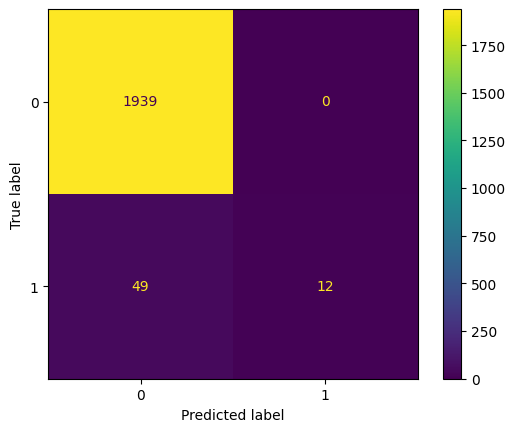

In [743]:
disp = ConfusionMatrixDisplay(target_matrices[0])
disp.plot();

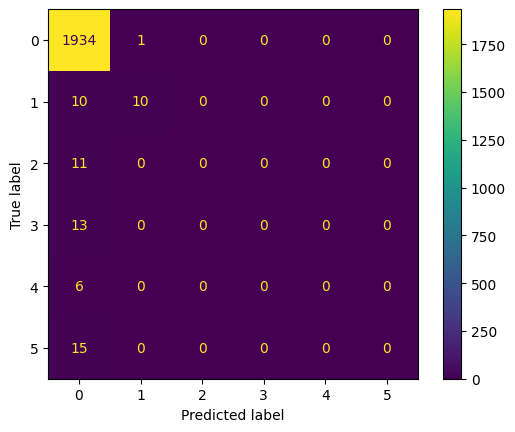

In [744]:
disp = ConfusionMatrixDisplay(ftype_matrices[0])
disp.plot();

### RandomForestClassifier

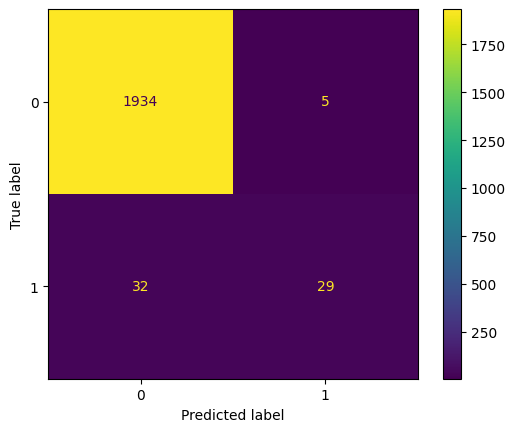

In [745]:
disp = ConfusionMatrixDisplay(target_matrices[1])
disp.plot();

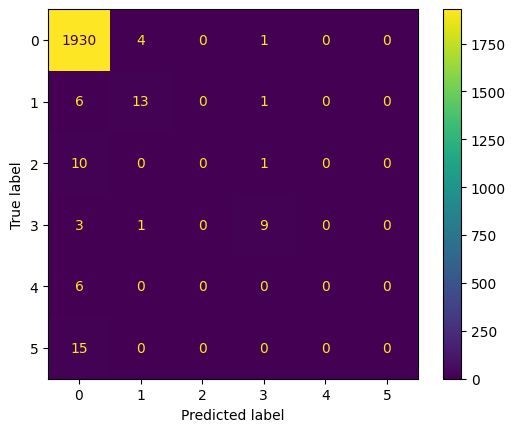

In [746]:
disp = ConfusionMatrixDisplay(ftype_matrices[1])
disp.plot();

### AdaBoostClassifier

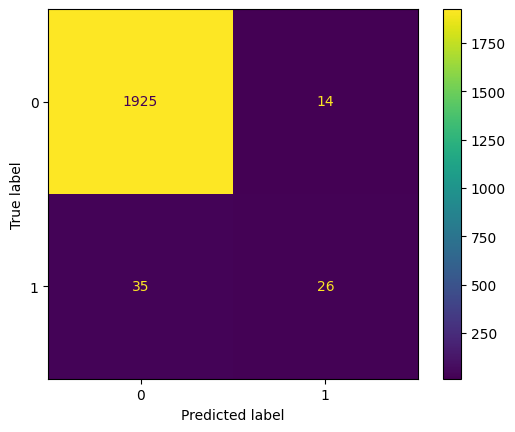

In [747]:
disp = ConfusionMatrixDisplay(target_matrices[2])
disp.plot();

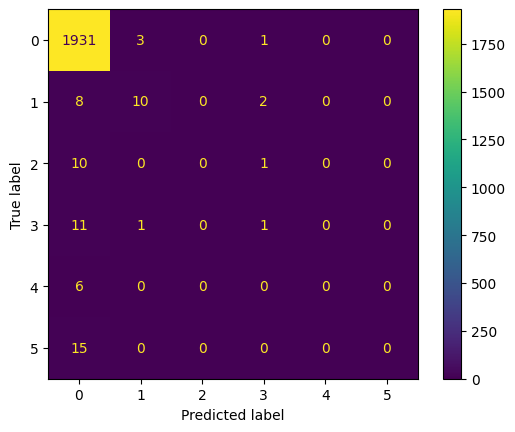

In [748]:
disp = ConfusionMatrixDisplay(ftype_matrices[2])
disp.plot();

### GradientBoostingClassifier

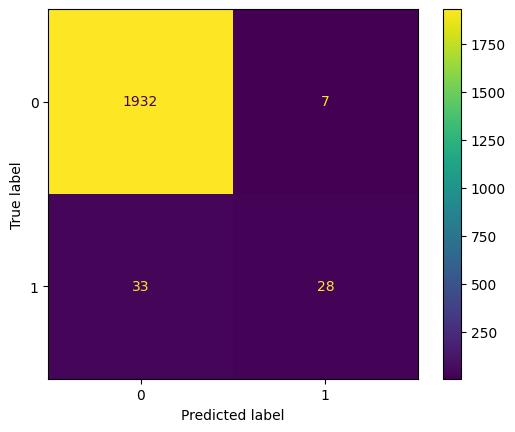

In [749]:
disp = ConfusionMatrixDisplay(target_matrices[3])
disp.plot();

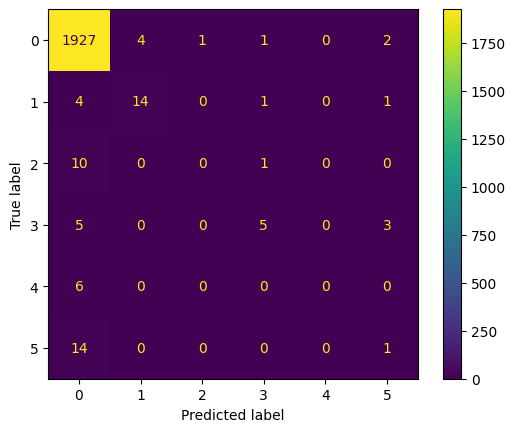

In [750]:
disp = ConfusionMatrixDisplay(ftype_matrices[3])
disp.plot();

### HistGradientBoostingClassifier

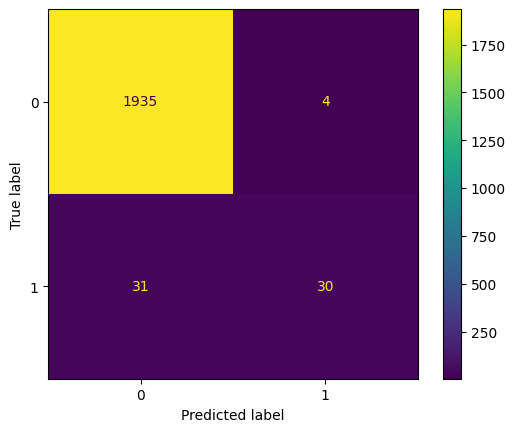

In [751]:
disp = ConfusionMatrixDisplay(target_matrices[4])
disp.plot();

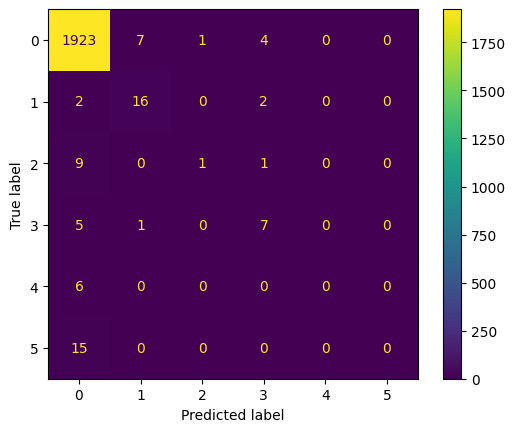

In [752]:
disp = ConfusionMatrixDisplay(ftype_matrices[4])
disp.plot();

### XGBClassifier

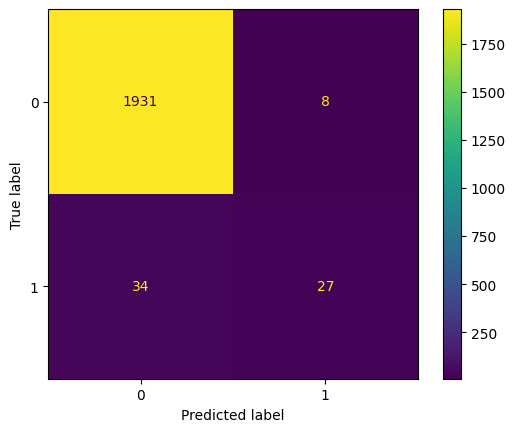

In [753]:
disp = ConfusionMatrixDisplay(target_matrices[5])
disp.plot();

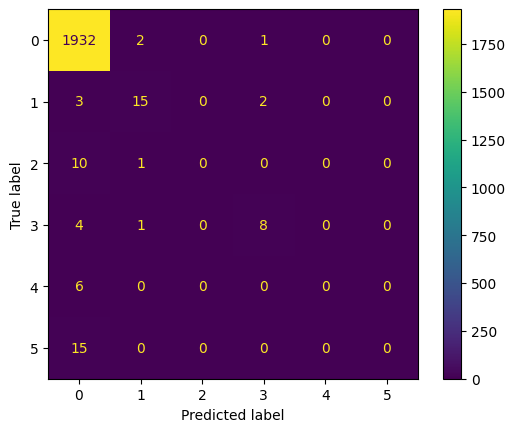

In [754]:
disp = ConfusionMatrixDisplay(ftype_matrices[5])
disp.plot();

### LGBMClassifier

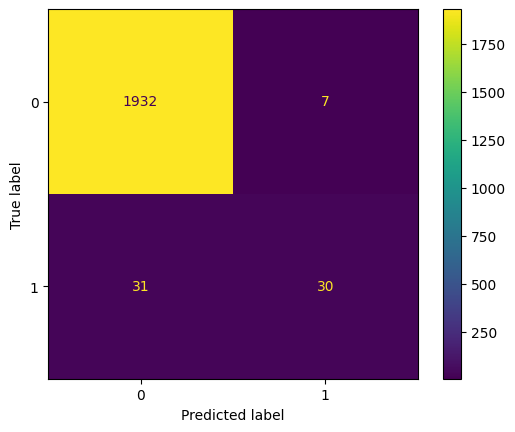

In [755]:
disp = ConfusionMatrixDisplay(target_matrices[6])
disp.plot();

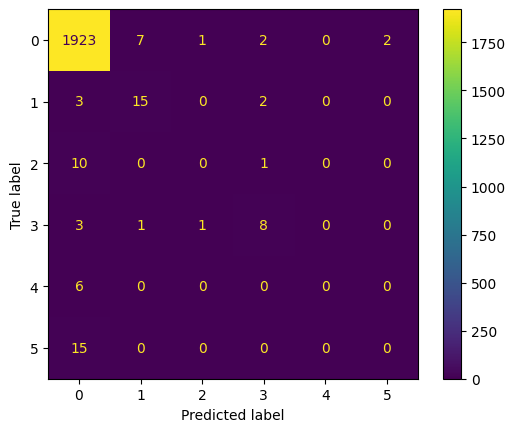

In [756]:
disp = ConfusionMatrixDisplay(ftype_matrices[6])
disp.plot();

### CatBoostClassifier

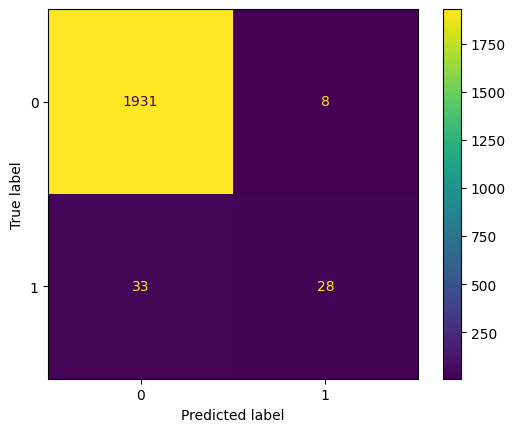

In [757]:
disp = ConfusionMatrixDisplay(target_matrices[7])
disp.plot();

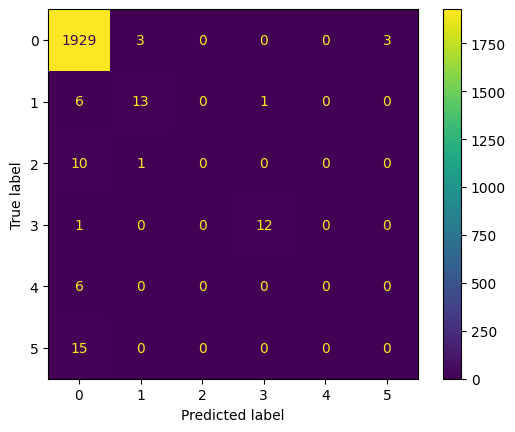

In [758]:
disp = ConfusionMatrixDisplay(ftype_matrices[7])
disp.plot();

### MyBaggingClassifier

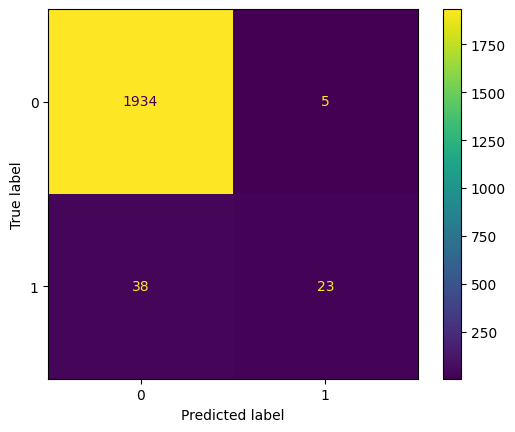

In [759]:
disp = ConfusionMatrixDisplay(target_matrices[8])
disp.plot();

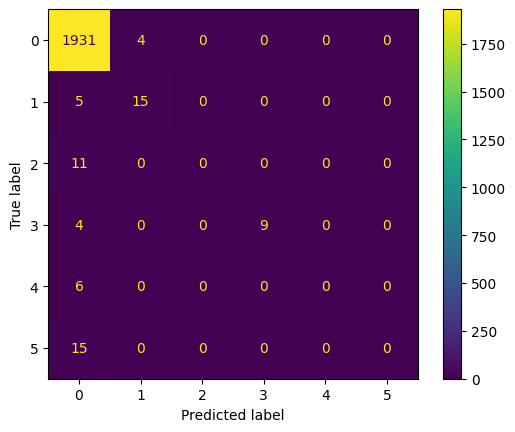

In [760]:
disp = ConfusionMatrixDisplay(ftype_matrices[8])
disp.plot();

### MyAdaBoosting

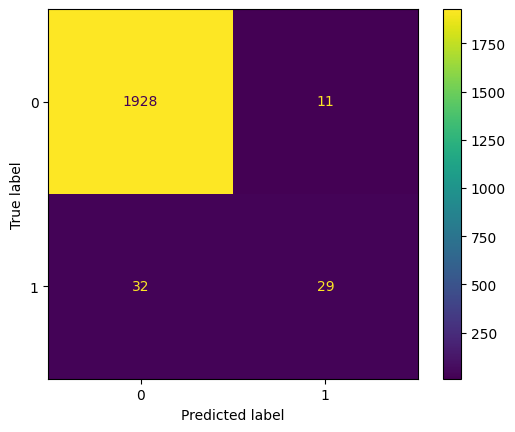

In [761]:
disp = ConfusionMatrixDisplay(target_matrices[9])
disp.plot();

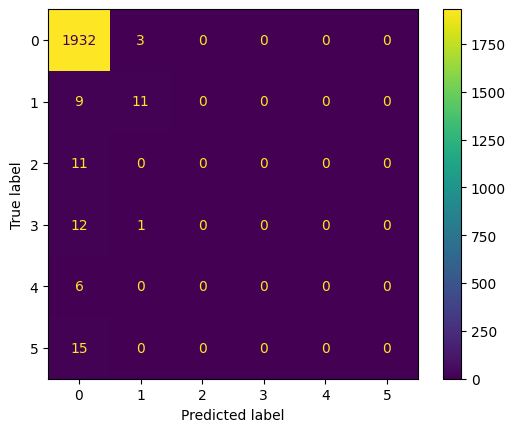

In [762]:
disp = ConfusionMatrixDisplay(ftype_matrices[9])
disp.plot();

## Метрики

In [763]:
target_results

model  fit_time  accuracy        f1  recall
0               BaggingClassifier  0.048248    0.9755  0.967430  0.9755
1          RandomForestClassifier  0.439547    0.9815  0.978935  0.9815
2              AdaBoostClassifier  0.092141    0.9755  0.973019  0.9755
3      GradientBoostingClassifier  0.178984    0.9800  0.977358  0.9800
4  HistGradientBoostingClassifier  0.033734    0.9825  0.980074  0.9825
5                   XGBClassifier  0.012360    0.9790  0.976226  0.9790
6                  LGBMClassifier  0.009984    0.9810  0.978732  0.9810
7              CatBoostClassifier  0.067621    0.9795  0.976924  0.9795
8             MyBaggingClassifier  0.035600    0.9785  0.974605  0.9785
9                   MyAdaBoosting  0.103696    0.9785  0.976323  0.9785

In [764]:
ftype_results

model  fit_time  accuracy        f1  recall
0               BaggingClassifier  0.076597    0.9720  0.960144  0.9720
1          RandomForestClassifier  0.148609    0.9760  0.967873  0.9760
2              AdaBoostClassifier  0.015497    0.9710  0.960763  0.9710
3      GradientBoostingClassifier  0.379018    0.9735  0.966989  0.9735
4  HistGradientBoostingClassifier  0.045136    0.9735  0.966818  0.9735
5                   XGBClassifier  0.010405    0.9775  0.969368  0.9775
6                  LGBMClassifier  0.033356    0.9730  0.966305  0.9730
7              CatBoostClassifier  0.220893    0.9770  0.969617  0.9770
8             MyBaggingClassifier  0.669188    0.9775  0.969367  0.9775
9                   MyAdaBoosting  0.022480    0.9715  0.959964  0.9715

- Лучший результат показывают `RandomForestClassifier`, `HistGradientBoostingClassifier` и `LGBMClassifier`
- На задаче бинарной классификации дольше всего обучался `GradientBoostingClassifier`, а на задаче классификации с большим количеством классов: `MyBaggingClassifier`